In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
% cd gdrive/MyDrive/share

/content/gdrive/MyDrive/share


In [ ]:
! git clone https://gitlab.com/tomaye/abstrct.git 

In [3]:
! ls abstrct

AbstRCT_corpus	get_stats.py  LICENSE  README.md


In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os, re


In [5]:
nltk.download('book')

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/dependency_treebank.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    

True

In [6]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

In [8]:
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [9]:
fname = './abstrct/AbstRCT_corpus/data/train/neoplasm_train/10561201.txt'
annot = './abstrct/AbstRCT_corpus/data/train/neoplasm_train/10561201.ann'

In [10]:
raw = [line for line in open(fname, 'r')][0]

In [11]:
raw

' A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer. The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL). Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone. Those who received prednisone alone could have mitoxantrone added after 6 weeks if there was no improvement in pain. HQL was assessed before treatment initiation and then every 3 weeks using the European Organization for Research and Treatment of Cancer Quality-of-Life Questionnaire C30 (EORTC QLQ-C30) and the Quality of Life Module-Prostate 14 (QOLM-P14), a trial-specific module developed for this study. An intent-to-treat analysis was used to determine the mean duration of HQL improvement and differences in improvement duration between groups of patients. At 6 we

In [12]:
! cat abstrct/AbstRCT_corpus/data/train/neoplasm_train/10561201.ann

T1	MajorClaim 1 162	A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.
T2	Premise 992 1058	At 6 weeks, both groups showed improvement in several HQL domains,
T3	Premise 1063 1187	only physical functioning and pain were better in the mitoxantrone-plus-prednisone group than in the prednisone-alone group.
T4	Premise 1188 1447	After 6 weeks, patients taking prednisone showed no improvement in HQL scores, whereas those taking mitoxantrone plus prednisone showed significant improvements in global quality of life (P =.009), four functioning domains, and nine symptoms (.001 < P <. 01),
T6	Premise 1452 1568	the improvement (> 10 units on a scale of 0 to100) lasted longer than in the prednisone-alone group (.004 < P <.05).
T7	Premise 1569 1768	The addition of mitoxantrone to prednisone after failure of prednisone alone was associated with improvements in pain, pain impact, pain relief, 

In [13]:
words = raw.strip().split()
len(words)

290

In [14]:
words[:10]

['A',
 'combination',
 'of',
 'mitoxantrone',
 'plus',
 'prednisone',
 'is',
 'preferable',
 'to',
 'prednisone']

In [15]:
from collections import Counter
c = Counter(words)

c.most_common(5)

[('of', 14), ('in', 11), ('and', 11), ('prednisone', 10), ('the', 8)]

<BarContainer object of 5 artists>

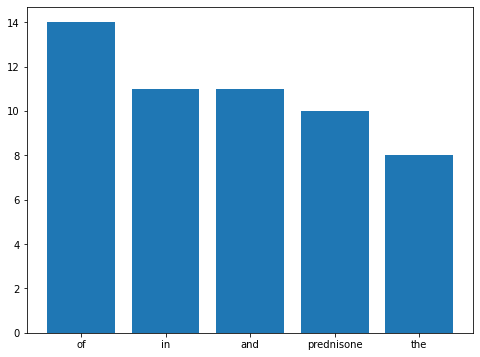

In [16]:
d = dict(c.most_common(5))
plt.bar(d.keys(), d.values())

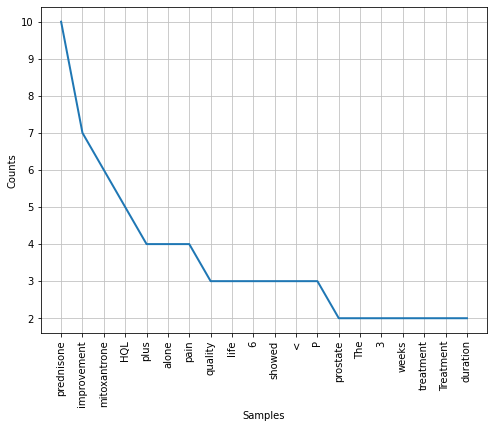

In [17]:
cleaned = words[:]

for word in words:
  if word in stopwords.words('english'):
    cleaned.remove(word)

freq = nltk.FreqDist(cleaned)
freq.plot(20, cumulative=False)

In [18]:
sentences = raw.strip()

In [19]:
sentences.split('.')

['A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer',
 ' The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL)',
 ' Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone',
 ' Those who received prednisone alone could have mitoxantrone added after 6 weeks if there was no improvement in pain',
 ' HQL was assessed before treatment initiation and then every 3 weeks using the European Organization for Research and Treatment of Cancer Quality-of-Life Questionnaire C30 (EORTC QLQ-C30) and the Quality of Life Module-Prostate 14 (QOLM-P14), a trial-specific module developed for this study',
 ' An intent-to-treat analysis was used to determine the mean duration of HQL improvement and differences in improvement duration between groups 

In [20]:
sentences = nltk.sent_tokenize(raw.strip())
for sent in sentences:
  print(sent)
  print()
len(sentences)

A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.

The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL).

Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone.

Those who received prednisone alone could have mitoxantrone added after 6 weeks if there was no improvement in pain.

HQL was assessed before treatment initiation and then every 3 weeks using the European Organization for Research and Treatment of Cancer Quality-of-Life Questionnaire C30 (EORTC QLQ-C30) and the Quality of Life Module-Prostate 14 (QOLM-P14), a trial-specific module developed for this study.

An intent-to-treat analysis was used to determine the mean duration of HQL improvement and differences in improvement duration between groups of patients.

At 

11

In [21]:
annotated = []
with open(annot, 'r') as infile:
  r = infile.readlines()
  for row in r:
    if re.match('^T\d', row):
      annotated.append(row.strip().split('\t'))

for a in annotated:
  print(a)

len(annotated)

['T1', 'MajorClaim 1 162', 'A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.']
['T2', 'Premise 992 1058', 'At 6 weeks, both groups showed improvement in several HQL domains,']
['T3', 'Premise 1063 1187', 'only physical functioning and pain were better in the mitoxantrone-plus-prednisone group than in the prednisone-alone group.']
['T4', 'Premise 1188 1447', 'After 6 weeks, patients taking prednisone showed no improvement in HQL scores, whereas those taking mitoxantrone plus prednisone showed significant improvements in global quality of life (P =.009), four functioning domains, and nine symptoms (.001 < P <. 01),']
['T6', 'Premise 1452 1568', 'the improvement (> 10 units on a scale of 0 to100) lasted longer than in the prednisone-alone group (.004 < P <.05).']
['T7', 'Premise 1569 1768', 'The addition of mitoxantrone to prednisone after failure of prednisone alone was associ

7

In [22]:
def cosine_similarity(sent1, sent2):
  """
  1 - collect all the words in sent1, sent2
  2 - create 2 vectors
  3 - calculate the cosine between the vectors (1 == equal, 0 == "orthogonal" i.e., FAR away)
  """
  first = nltk.word_tokenize(sent1)
  second = nltk.word_tokenize(sent2)
  
  x = { w for w in first if w not in stopwords.words('english') }
  y = { w for w in second if w not in stopwords.words('english') }

  rvector = x.union(y)
  l1 = [1 if w in x else 0 for w in rvector]
  l2 = [1 if w in y else 0 for w in rvector]
  
  c = 0
  for i in range(len(rvector)):
    c += l1[i] * l2[i]

  cosine = c / float((sum(l1) * sum(l2)) ** 0.5)
  return cosine

In [23]:
s1 = "hello marco"
s2 = "hello world"
cosine_similarity(s1, s2)

0.5

We're trying to find the best match between the `7` identified arguments in the `annotation` file and the `11` sentences that we were able to tokenize from the `raw` text.

In [24]:
for sent1 in sentences:
  match = ''
  similarity = 0
  for annotation in annotated:
    sent2 = annotation[2]
    cs = cosine_similarity(sent1, sent2)
    if cs > similarity:
      similarity = cs
      match = sent2

  print(f'ORIG: {sent1}')
  print(f'MATCH: {match}')
  print(f'SCORE: {similarity}')
  print()

ORIG: A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.
MATCH: A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.
SCORE: 1.0

ORIG: The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL).
MATCH: The addition of mitoxantrone to prednisone after failure of prednisone alone was associated with improvements in pain, pain impact, pain relief, insomnia, and global quality of life (.001 < P <.003).
SCORE: 0.34698895917974415

ORIG: Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone.
MATCH: A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormon

In [25]:
datadir = './abstrct/AbstRCT_corpus/data/train/neoplasm_train'
testdir = './abstrct/AbstRCT_corpus/data/test/neoplasm_test'

In [28]:
train_raw_files = [f for f in os.listdir(datadir) if f.endswith('.txt')]  # 350
train_ann_files = [f for f in os.listdir(datadir) if f.endswith('.ann')]  # 350

test_raw_files = [f for f in os.listdir(testdir) if f.endswith('.txt')]   # 100
test_ann_files = [f for f in os.listdir(testdir) if f.endswith('.ann')]   # 100

In [31]:
# I want 2 dictionaries of the form { 'fname' : raw_text }
def extract_annotated(fpath):
  result = []
  with open(fpath, 'r') as infile:
    r = infile.readlines()
    for row in r:
      if re.match('^T\d', row):
        arg_tag, annotation, text = row.strip().split('\t')
        fname = os.path.basename(fpath).replace('.ann', '')
        name = f'{fname}-{arg_tag}'    # 1234356-T1; 1233466-T2, ...
        # Claim 1 1234
        is_arg = annotation.split()[0]
        result.append((name, is_arg, text))
  return result

In [ ]:
extract_annotated(annot)

In [34]:
from collections import defaultdict

train_ann_dict = defaultdict(list)
test_ann_dict = defaultdict(list)

for f in train_ann_files:   # f = 123345.ann
  fname = f.replace('.ann', '')  # fname = 123345
  filepath = os.path.join(datadir, f)
  train_ann_dict[fname] = extract_annotated(filepath)

for f in test_ann_files:   # f = 123345.ann
  fname = f.replace('.ann', '')  # fname = 123345
  filepath = os.path.join(testdir, f)
  test_ann_dict[fname] = extract_annotated(filepath)

In [35]:
train_raw_dict = {}
test_raw_dict = {}

for f in train_raw_files:
  with open(os.path.join(datadir, f), 'r') as infile:
    train_raw_dict[f.replace('.txt', '')] = infile.read().strip()

for f in test_raw_files:
  with open(os.path.join(testdir, f), 'r') as infile:
    test_raw_dict[f.replace('.txt', '')] = infile.read().strip()


In [36]:
len(train_ann_dict)

350

In [41]:
def extract_sentences(raw_dict, ann_dict):
  data = []
  for fname, raw_text in raw_dict.items():
    sentences = nltk.sent_tokenize(raw_text.strip())
    arguments = [x[1] for x in ann_dict[fname]]
    annotated = [x[2] for x in ann_dict[fname]]
    for sent1 in sentences:
      match = ''
      similarity = 0
      annotated_arg = ''
      for arg, sent2 in zip(arguments, annotated):
        cs = cosine_similarity(sent1, sent2)
        if cs > similarity and cs > 0.8:
          similarity = cs
          match = sent2
          annotated_arg = arg
          break
      if not match:
        is_argumentative = 0
      else:
        is_argumentative = 1

      data.append((sent1, is_argumentative, annotated_arg))
  return data




In [42]:
train_data = extract_sentences(train_raw_dict, train_ann_dict)
test_data = extract_sentences(test_raw_dict, test_ann_dict)

In [44]:
len(list(filter(lambda x: x[1] == 0, train_data)))

2471

In [45]:
train = pd.DataFrame(train_data, columns=['text', 'label', 'arg'])
test = pd.DataFrame(test_data, columns=['text', 'label', 'arg'])

In [46]:
train.head()

text  label         arg
0  A combination of mitoxantrone plus prednisone ...      1  MajorClaim
1  The purpose of this study was to assess the ef...      0            
2  Men with metastatic prostate cancer (n = 161) ...      0            
3  Those who received prednisone alone could have...      0            
4  HQL was assessed before treatment initiation a...      0

In [47]:
train['arg'].value_counts()

              2471
Premise       1318
Claim          572
MajorClaim      57
Name: arg, dtype: int64

In [48]:
test.head()

text  label         arg
0  Data from experimental studies suggest that oc...      1  MajorClaim
1  To assess the antitumour effect of octreotide,...      0            
2  All patients, aged 59-75 years, were not liabl...      0            
3  Six patients were enrolled, 4 of these treated...      0            
4  The patients treated with octreotide showed a ...      1     Premise

In [53]:
def preprocess_text(text):
  tokeniser = RegexpTokenizer(r'\w+')
  tokens = tokeniser.tokenize(text)

  lemmatiser = WordNetLemmatizer()
  lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens ]

  keywords = [l for l in lemmas if l not in stopwords.words('english')]
  return keywords

In [55]:
x_train, y_train = train['text'], train['label']
x_test, y_test = test['text'], test['label']

In [56]:
y_train.value_counts()

0    2471
1    1947
Name: label, dtype: int64

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(analyzer=preprocess_text)

In [58]:
x_train_tfidf = vectoriser.fit_transform(x_train)

In [61]:
x_train_tfidf[:0]

<0x5336 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [62]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf_scores = cross_val_score(sgd_clf, x_train_tfidf, y_train, cv=5)

In [67]:
sgd_clf_scores.mean()

0.801724120260527

In [65]:
sgd_clf_pred = cross_val_predict(sgd_clf, x_train_tfidf, y_train, cv=5)

In [66]:
confusion_matrix(y_train, sgd_clf_pred)

array([[2062,  409],
       [ 467, 1480]])

In [68]:
grid = {'fit_intercept': [True, False],
        'early_stopping': [True, False],
        'loss': ['hinge', 'log', 'squared_hinge'],
        'penalty': ['l2', 'l1']}

search = GridSearchCV(estimator=sgd_clf, param_grid=grid)
search.fit(x_train_tfidf, y_train)
search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

{'early_stopping': False,
 'fit_intercept': True,
 'loss': 'log',
 'penalty': 'l1'}

In [70]:
grid_sgd_clf_scores = cross_val_score(search.best_estimator_, x_train_tfidf, y_train)
grid_sgd_clf_scores.mean()

0.8239032401879648

In [71]:
pipe = Pipeline([('vectoriser', vectoriser),
                 ('classifier', search.best_estimator_)])

pipe.fit(x_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(analyzer=<function preprocess_text at 0x7f288f92d4d0>)),
                ('classifier',
                 SGDClassifier(loss='log', penalty='l1', random_state=42))])

In [72]:
y_test_pred = pipe.predict(x_test)

In [73]:
accuracy_score(y_test, y_test_pred)

0.8163751987281399

In [74]:
confusion_matrix(y_test, y_test_pred)

array([[567, 103],
       [128, 460]])

In [76]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       670
           1       0.82      0.78      0.80       588

    accuracy                           0.82      1258
   macro avg       0.82      0.81      0.82      1258
weighted avg       0.82      0.82      0.82      1258

